In [61]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [62]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrAandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_C'

#file name
fname='F0592_FO_IMA_07018915_FORF253_CAL_0276-0303_Field_D.fits'

#Name of field
field='FieldD'

#wavelength of data
wavelength=25.2

In [63]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

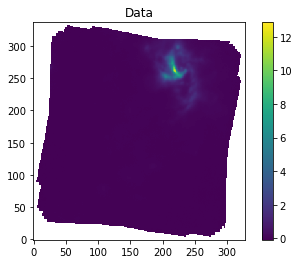

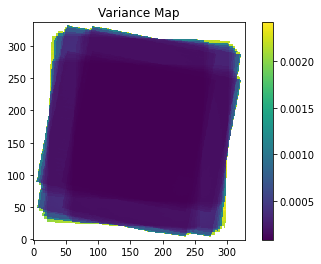

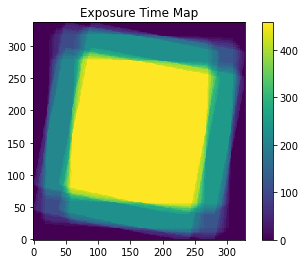

In [64]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

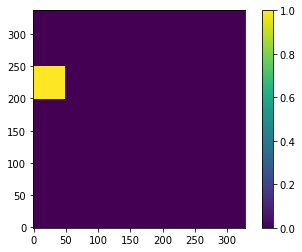

In [65]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.2,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[200:250,0:50]=1

mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [66]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

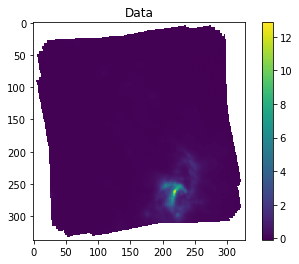

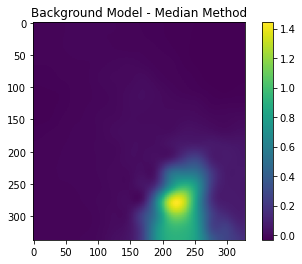

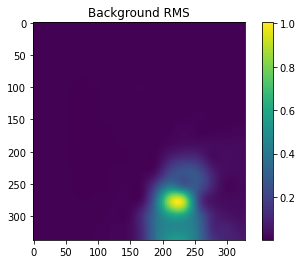

In [67]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [68]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

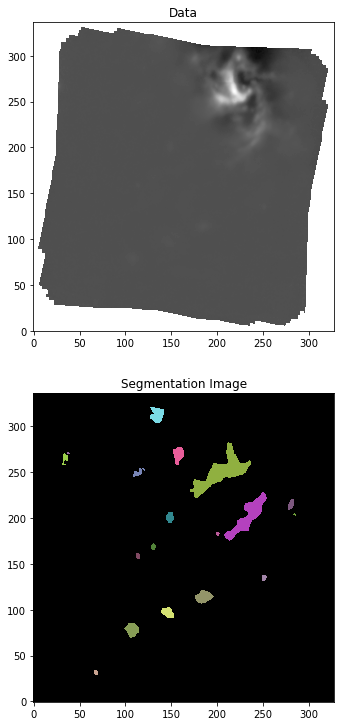

In [69]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [70]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,67.95964872637293,31.355317919318974,"266.45487815340124,-29.05661089320324",-0.013842873087559035,-0.006544894005956177,-0.18325703216677297,28.0,1.5947458083075539,1.308961048307363,-68.91316934950343,0.5589909859803304,0.1278568006177058,0.4178542526131887,0.5712213726390687,0.17920395746547457,1.2183294608878876,3.4353722293865276,3.8640212513953633,nan,2.8442397922549802,1.1271164901364383,nan
2,107.68835708967892,78.4266578600621,"266.44518058501114,-29.046570693236248",-0.010569938157389453,-0.0008966775251065569,-0.1605052769940737,179.0,3.518082562576839,3.2058293831639753,-46.62431296485145,0.08951621484012018,0.016479254545866722,0.08858085143286827,0.4118683462808216,0.08875663770214426,1.0974016836493923,7.925333406700125,11.057876416629473,nan,1.3327344711642006,8.164773825445437,nan
3,146.8415519111544,96.86702530167108,"266.4356258620002,-29.04263772550062",-0.002443170991555713,0.008729466159306904,1.0300770067982148,118.0,3.5894869577176403,2.3273324668259225,-35.51539358908668,0.11372537188873198,0.1011974490674729,0.14850963500348377,0.7613213979605754,0.3516253174225915,1.5423180868580746,7.123261164945547,15.492427989349142,nan,3.045940384338719,5.1014749555476255,nan
4,185.43632544005763,113.89510468993679,"266.42620812412065,-29.039005369800215",0.0022836527329636877,0.014896970948895437,2.964497218830192,199.0,4.034399716161436,2.7984587492133732,12.748896618594872,0.06466517023982878,-0.028520278630691627,0.12446510509602382,0.7203128322723485,0.3063506479035768,1.4416505933115777,8.175627348157747,16.02521967633343,nan,1.5973768402289397,11.978342466997303,nan
5,251.39993467472445,135.10011764657366,"266.41011322093414,-29.034480627550934",0.0043798494969709565,0.006330865782747071,0.20258770504790627,32.0,1.5725526990283436,1.2464486346169734,-86.01575189368806,0.6424970015486404,0.033169971472934254,0.4055350746098735,0.6097060973167339,0.20737242358419206,1.2616265567265674,3.341254896254916,4.0464403468803525,nan,2.811174270207267,1.6511596199701422,nan
6,114.00093544032268,158.46345332131645,"266.44363733752,-29.02949638184458",0.018993901012156814,0.005375007214453559,0.15050020200469966,28.0,1.5410791333633385,1.172792731141001,-66.21019367523328,0.6772515108139768,0.2258737116857763,0.47085303572747417,0.648727892913516,0.23897955286602868,1.3140251405412742,3.2246282187383803,1.4844183281920373,nan,1.8258267171073843,1.0674148766203833,nan
7,130.91109763015328,168.68687996675362,"266.43951123593985,-29.02731584163638",0.01732144528769786,0.014446622333953052,0.37561218068277935,26.0,1.6324057784325892,1.23537196274464,84.6179056095961,0.6527830049780252,-0.05229042336961096,0.3777331253898618,0.6536697238429254,0.24322005039039674,1.3213880739254067,3.408756564250925,3.1517282381547442,nan,3.313720957786914,0.6615381725105037,nan
8,240.04432620141375,210.27838980394228,"266.41288608546523,-29.018442906563372",0.5195453110544975,0.1783269241343091,131.96192385938872,740.0,12.909415950448423,3.8545688015785426,52.53726898570328,0.04462474813352672,-0.05919507623821918,0.028680908617203654,0.9543827829187275,0.7014141603017563,3.3491206448725714,22.433336299640256,538.7608166311156,nan,1.311640238057724,351.2097424200465,nan


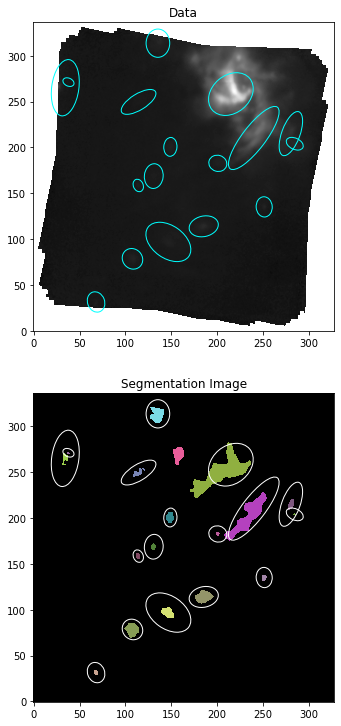

In [71]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

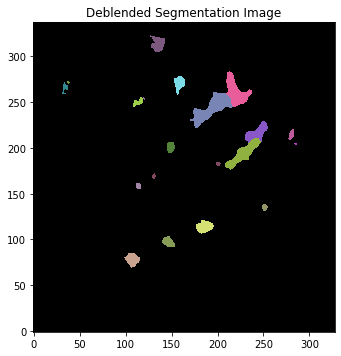

In [72]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [73]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,67.95964872637293,31.355317919318974,"266.45487815340124,-29.05661089320324",-0.013842873087559035,-0.006544894005956177,-0.18325703216677297,28.0,1.5947458083075539,1.308961048307363,-68.91316934950343,0.5589909859803304,0.1278568006177058,0.4178542526131887,0.5712213726390687,0.17920395746547457,1.2183294608878876,3.4353722293865276,3.8640212513953633,nan,2.8442397922549802,1.1271164901364383,nan
2,107.68835708967892,78.4266578600621,"266.44518058501114,-29.046570693236248",-0.010569938157389453,-0.0008966775251065569,-0.1605052769940737,179.0,3.518082562576839,3.2058293831639753,-46.62431296485145,0.08951621484012018,0.016479254545866722,0.08858085143286827,0.4118683462808216,0.08875663770214426,1.0974016836493923,7.925333406700125,11.057876416629473,nan,1.3327344711642006,8.164773825445437,nan
3,146.8415519111544,96.86702530167108,"266.4356258620002,-29.04263772550062",-0.002443170991555713,0.008729466159306904,1.0300770067982148,118.0,3.5894869577176403,2.3273324668259225,-35.51539358908668,0.11372537188873198,0.1011974490674729,0.14850963500348377,0.7613213979605754,0.3516253174225915,1.5423180868580746,7.123261164945547,15.492427989349142,nan,3.045940384338719,5.1014749555476255,nan
4,185.43632544005763,113.89510468993679,"266.42620812412065,-29.039005369800215",0.0022836527329636877,0.014896970948895437,2.964497218830192,199.0,4.034399716161436,2.7984587492133732,12.748896618594872,0.06466517023982878,-0.028520278630691627,0.12446510509602382,0.7203128322723485,0.3063506479035768,1.4416505933115777,8.175627348157747,16.02521967633343,nan,1.5973768402289397,11.978342466997303,nan
5,251.39993467472445,135.10011764657366,"266.41011322093414,-29.034480627550934",0.0043798494969709565,0.006330865782747071,0.20258770504790627,32.0,1.5725526990283436,1.2464486346169734,-86.01575189368806,0.6424970015486404,0.033169971472934254,0.4055350746098735,0.6097060973167339,0.20737242358419206,1.2616265567265674,3.341254896254916,4.0464403468803525,nan,2.811174270207267,1.6511596199701422,nan
6,114.00093544032268,158.46345332131645,"266.44363733752,-29.02949638184458",0.018993901012156814,0.005375007214453559,0.15050020200469966,28.0,1.5410791333633385,1.172792731141001,-66.21019367523328,0.6772515108139768,0.2258737116857763,0.47085303572747417,0.648727892913516,0.23897955286602868,1.3140251405412742,3.2246282187383803,1.4844183281920373,nan,1.8258267171073843,1.0674148766203833,nan
7,130.91109763015328,168.68687996675362,"266.43951123593985,-29.02731584163638",0.01732144528769786,0.014446622333953052,0.37561218068277935,26.0,1.6324057784325892,1.23537196274464,84.6179056095961,0.6527830049780252,-0.05229042336961096,0.3777331253898618,0.6536697238429254,0.24322005039039674,1.3213880739254067,3.408756564250925,3.1517282381547442,nan,3.313720957786914,0.6615381725105037,nan
8,200.7985411895033,182.6096153089684,"266.42246021395806,-29.024346211455626",0.024554303586465112,0.02825596593749268,0.4520954549998829,16.0,1.1662847382275843,1.0306009828631002,-17.00357167340227,0.7528189704041124,0.11539498798006086,0.9238530750527804,0.4681263290939747,0.11633844713657504,1.1316549834714331,2.5915639666364663,3.0953101940269785,nan,3.405381034042837,0.634912030330222,nan


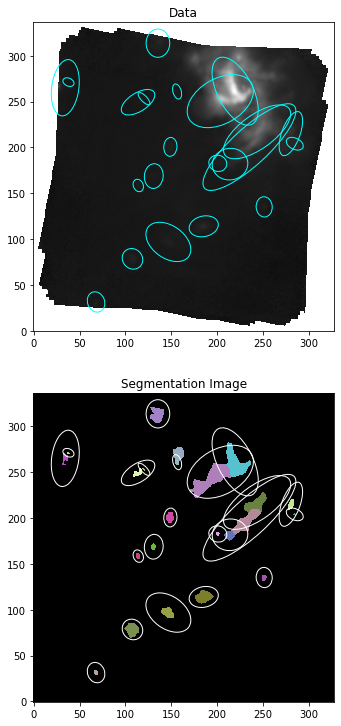

In [74]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [75]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [76]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [77]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,67.95964872637293,31.355317919318974,"266.45487815340124,-29.05661089320324",-0.013842873087559035,-0.006544894005956177,-0.18325703216677297,28.0,1.5947458083075539,1.308961048307363,-68.91316934950343,0.5589909859803304,0.1278568006177058,0.4178542526131887,0.5712213726390687,0.17920395746547457,1.2183294608878876,3.4353722293865276,3.8640212513953633,0.43211893926630596,2.8442397922549802,1.1271164901364383,0.11646183,-0.0065666633013065565,-0.006558937956155662,8.265965441942034e-05,3.302759890509564
2,107.68835708967892,78.4266578600621,"266.44518058501114,-29.046570693236248",-0.010569938157389453,-0.0008966775251065569,-0.1605052769940737,179.0,3.518082562576839,3.2058293831639753,-46.62431296485145,0.08951621484012018,0.016479254545866722,0.08858085143286827,0.4118683462808216,0.08875663770214426,1.0974016836493923,7.925333406700125,11.057876416629473,0.18878900654091138,1.3327344711642006,8.164773825445437,0.12623824,-0.0012929419605932524,-0.0013047537202019995,0.001862600255701399,22.97992940244679
3,146.8415519111544,96.86702530167108,"266.4356258620002,-29.04263772550062",-0.002443170991555713,0.008729466159306904,1.0300770067982148,118.0,3.5894869577176403,2.3273324668259225,-35.51539358908668,0.11372537188873198,0.1011974490674729,0.14850963500348377,0.7613213979605754,0.3516253174225915,1.5423180868580746,7.123261164945547,15.492427989349142,0.36623169506290637,3.045940384338719,5.1014749555476255,0.102001935,0.008878408944335605,0.008662173405151049,0.002332606459445098,4.811559579264565
4,185.43632544005763,113.89510468993679,"266.42620812412065,-29.039005369800215",0.0022836527329636877,0.014896970948895437,2.964497218830192,199.0,4.034399716161436,2.7984587492133732,12.748896618594872,0.06466517023982878,-0.028520278630691627,0.12446510509602382,0.7203128322723485,0.3063506479035768,1.4416505933115777,8.175627348157747,16.02521967633343,0.22173878268861305,1.5973768402289397,11.978342466997303,0.13151778,0.014385904451946666,0.01452059212875463,0.0029332752761530713,6.891488769084887
5,251.39993467472445,135.10011764657366,"266.41011322093414,-29.034480627550934",0.0043798494969709565,0.006330865782747071,0.20258770504790627,32.0,1.5725526990283436,1.2464486346169734,-86.01575189368806,0.6424970015486404,0.033169971472934254,0.4055350746098735,0.6097060973167339,0.20737242358419206,1.2616265567265674,3.341254896254916,4.0464403468803525,0.1692909765564591,2.811174270207267,1.6511596199701422,0.053736866,0.006171577456251222,0.0061961165909759554,0.0012910110004166427,3.28910649059503
6,114.00093544032268,158.46345332131645,"266.44363733752,-29.02949638184458",0.018993901012156814,0.005375007214453559,0.15050020200469966,28.0,1.5410791333633385,1.172792731141001,-66.21019367523328,0.6772515108139768,0.2258737116857763,0.47085303572747417,0.648727892913516,0.23897955286602868,1.3140251405412742,3.2246282187383803,1.4844183281920373,0.10078017011057396,1.8258267171073843,1.0674148766203833,0.04901549,0.005381821886312943,0.0053250329831283725,0.0006676419769611578,2.3981316688938077
7,130.91109763015328,168.68687996675362,"266.43951123593985,-29.02731584163638",0.01732144528769786,0.014446622333953052,0.37561218068277935,26.0,1.6324057784325892,1.23537196274464,84.6179056095961,0.6527830049780252,-0.05229042336961096,0.3777331253898618,0.6536697238429254,0.24322005039039674,1.3213880739254067,3.408756564250925,3.15

In [78]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [79]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,67.95964872645605,31.355317919309556,"266.45487815340124,-29.05661089320324",0.9180803218913982,0.10262976630898271,2.327338797386165,0.22532321268942737,nan,nan,nan,nan,nan,nan
2,107.68835708959483,78.42665785997059,"266.44518058501114,-29.046570693236248",1.7732699790398925,0.04315955203107878,5.227357256320544,0.08643775113909376,8.377518781623188,0.13064852433827054,10.582882438958805,0.17541033543974477,11.823805159838185,0.22125348752033758
3,146.84155191107985,96.86702530171887,"266.4356258620002,-29.04263772550062",1.2422133300062435,0.04332265668350344,3.9677423558174727,0.08667670029400562,6.682985496121841,0.1300370741720315,9.051921789967997,0.17336025320494466,11.505489802799055,0.2167130965578036
4,185.43632544002836,113.89510469001821,"266.42620812412065,-29.039005369800215",2.800341980673772,0.043019689151287795,7.685858753502244,0.08608063937211456,11.520849284264525,0.1290934161552375,14.039836218096898,0.17210349803833092,15.507561315090427,0.2151693439097607
5,251.39993467474523,135.1001176465491,"266.41011322093414,-29.034480627550934",1.3000252050937535,0.043816903253585796,2.563144355666298,0.08846213423497953,3.5478240203462885,0.13390123988453728,4.129219272026117,0.18064047479019274,4.122498057227046,0.23112661957392427
6,114.00093544016795,158.46345332132475,"266.44363733752,-29.02949638184458",0.8846836784195238,0.04276535625691049,1.4436311962796329,0.08551457686377029,1.4638377788773902,0.12832171793514688,1.5434956856346003,0.1711360217531016,1.6579911193682642,0.21397114590232647
7,130.9110976302085,168.68687996674822,"266.43951123593985,-29.02731584163638",0.5472460854085994,0.042510996157249986,1.5042498947920973,0.08501062239368228,2.5258394841637157,0.12751343211661273,2.903878299052729,0.17000724597903924,3.0273616116046993,0.21252000344901167
8,200.79854118964502,182.6096153090214,"266.42246021395806,-29.024346211455626",0.7969262784358119,0.043022090679500344,2.1463699381411554,0.08600344804300686,3.2246746365827033,0.12897465545078818,4.320516663574551,0.17199829339742337,6.199512989569471,0.21500147441968792


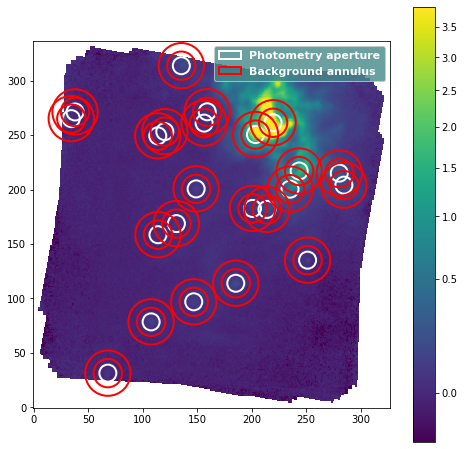

In [80]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [81]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [82]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-82-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,67.95964872645605,31.355317919309556,"266.45487815340124,-29.05661089320324",nan,nan,0.0007865301937174321,0.0013038411536080905,nan,nan,0.000786530193717432,nan
2,107.68835708959483,78.42665785997059,"266.44518058501114,-29.046570693236248",8.377518781623188,0.13064852433827054,-0.0010853440499680462,-0.0014682108700124704,8.585630893132631,0.13064852433827054,0.0,21.410738345711156
3,146.84155191107985,96.86702530171887,"266.4356258620002,-29.04263772550062",6.682985496121841,0.1300370741720315,0.0038789225335411903,0.004635681633559545,5.939211428478878,0.1300370741720315,0.0038789225335411908,5.727059322810111
4,185.43632544002836,113.89510469001821,"266.42620812412065,-29.039005369800215",11.520849284264525,0.1290934161552375,-0.00018223813875541063,-0.0006201568413639369,11.555793009118462,0.1290934161552375,0.0,28.990746077797624
5,251.39993467474523,135.1001176465491,"266.41011322093414,-29.034480627550934",3.5478240203462885,0.13390123988453728,-0.0005848681392516531,-0.0006101966778490229,3.6599710795371925,0.13390123988453728,0.0,9.015649913385836
6,114.00093544016795,158.46345332132475,"266.44363733752,-29.02949638184458",1.4638377788773902,0.12832171793514688,0.0009060405077571752,0.0017887775158691277,1.2901066903916827,0.12832171793514688,0.0009060405077571752,2.1159035864359423
7,130.9110976302085,168.68687996674822,"266.43951123593985,-29.02731584163638",2.5258394841637157,0.12751343211661273,3.2646027465456015e-05,0.000558937870934006,2.519579686905481,0.12751343211661273,3.264602746545602e-05,6.209479212275684
8,200.79854118964502,182.6096153090214,"266.42246021395806,-29.024346211455626",3.2246746365827033,0.12897465545078818,0.0007041210673292359,0.003246736769375098,3.0896611152163818,0.12897465545078818,0.0007041210673292361,5.4203869823826105


In [83]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [84]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,67.95964872637293,31.355317919318974,"266.45487815340124,-29.05661089320324",-0.013842873087559035,-0.006544894005956177,-0.18325703216677297,28.0,1.5947458083075539,1.308961048307363,-68.91316934950343,0.5589909859803304,0.1278568006177058,0.4178542526131887,0.5712213726390687,0.17920395746547457,1.2183294608878876,3.4353722293865276,3.8640212513953633,0.43211893926630596,2.8442397922549802,1.1271164901364383,0.11646183,-0.0065666633013065565,-0.006558937956155662,8.265965441942034e-05,3.302759890509564,0.9180803218913982,0.10262976630898271,2.327338797386165,0.22532321268942737,nan,nan,nan,nan,nan,nan,0.0007865301937174321,0.0013038411536080905,nan,nan,0.000786530193717432,nan,0.9013230693168409,2.2603097870879356,nan,nan,2.575753157282903,3.981189417655949,nan,nan,3.981189417655949,C7FieldD,25.2
2,107.68835708967892,78.4266578600621,"266.44518058501114,-29.046570693236248",-0.010569938157389453,-0.0008966775251065569,-0.1605052769940737,179.0,3.518082562576839,3.2058293831639753,-46.62431296485145,0.08951621484012018,0.016479254545866722,0.08858085143286827,0.4118683462808216,0.08875663770214426,1.0974016836493923,7.925333406700125,11.057876416629473,0.18878900654091138,1.3327344711642006,8.164773825445437,0.12623824,-0.0012929419605932524,-0.0013047537202019995,0.001862600255701399,22.97992940244679,1.7732699790398925,0.04315955203107878,5.227357256320544,0.08643775113909376,8.377518781623188,0.13064852433827054,10.582882438958805,0.17541033543974477,11.823805159838185,0.22125348752033758,-0.0010853440499680462,-0.0014682108700124704,8.585630893132631,0.13064852433827054,0.0,21.410738345711156,1.7963935469853862,5.319851528102519,10.952859526086705,12.40189435847553,8.538180466695787,17.232403605336007,22.02170228147274,20.581891367788305,22.02170228147274,C7FieldD,25.2
3,146.8415519111544,96.86702530167108,"266.4356258620002,-29.04263772550062",-0.002443170991555713,0.008729466159306904,1.0300770067982148,118.0,3.5894869577176403,2.3273324668259225,-35.51539358908668,0.11372537188873198,0.1011974490674729,0.14850963500348377,0.7613213979605754,0.3516253174225915,1.5423180868580746,7.123261164945547,15.492427989349142,0.36623169506290637,3.045940384338719,5.1014749555476255,0.102001935,0.008878408944335605,0.008662173405151049,0.002332606459445098,4.811559579264565,1.2422133300062435,0.04332265668350344,3.9677423558174727,0.08667670029400562,6.682985496121841,0.1300370741720315,9.051921789967997,0.17336025320494466,11.505489802799055,0.2167130965578036,0.0038789225335411903,0.004635681633559545,5.939211428478878,0.1300370741720315,0.0038789225335411908,5.727059322810111,1.1595717669348031,3.6371761035317114,7.7296567808249526,9.439450726013046,3.226088968200731

In [85]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [86]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,67.95964872637293,31.355317919318974,"266.45487815340124,-29.05661089320324",-0.013842873087559035,-0.006544894005956177,-0.18325703216677297,28.0,1.5947458083075539,1.308961048307363,-68.91316934950343,0.5589909859803304,0.1278568006177058,0.4178542526131887,0.5712213726390687,0.17920395746547457,1.2183294608878876,3.4353722293865276,3.8640212513953633,0.43211893926630596,2.8442397922549802,1.1271164901364383,0.11646183,-0.0065666633013065565,-0.006558937956155662,8.265965441942034e-05,3.302759890509564,0.9180803218913982,0.10262976630898271,2.327338797386165,0.22532321268942737,nan,nan,nan,nan,nan,nan,0.0007865301937174321,0.0013038411536080905,nan,nan,0.000786530193717432,nan,0.9013230693168409,2.2603097870879356,nan,nan,2.575753157282903,3.981189417655949,nan,nan,3.981189417655949,C7FieldD,25.2
2,107.68835708967892,78.4266578600621,"266.44518058501114,-29.046570693236248",-0.010569938157389453,-0.0008966775251065569,-0.1605052769940737,179.0,3.518082562576839,3.2058293831639753,-46.62431296485145,0.08951621484012018,0.016479254545866722,0.08858085143286827,0.4118683462808216,0.08875663770214426,1.0974016836493923,7.925333406700125,11.057876416629473,0.18878900654091138,1.3327344711642006,8.164773825445437,0.12623824,-0.0012929419605932524,-0.0013047537202019995,0.001862600255701399,22.97992940244679,1.7732699790398925,0.04315955203107878,5.227357256320544,0.08643775113909376,8.377518781623188,0.13064852433827054,10.582882438958805,0.17541033543974477,11.823805159838185,0.22125348752033758,-0.0010853440499680462,-0.0014682108700124704,8.585630893132631,0.13064852433827054,0.0,21.410738345711156,1.7963935469853862,5.319851528102519,10.952859526086705,12.40189435847553,8.538180466695787,17.232403605336007,22.02170228147274,20.581891367788305,22.02170228147274,C7FieldD,25.2
3,146.8415519111544,96.86702530167108,"266.4356258620002,-29.04263772550062",-0.002443170991555713,0.008729466159306904,1.0300770067982148,118.0,3.5894869577176403,2.3273324668259225,-35.51539358908668,0.11372537188873198,0.1011974490674729,0.14850963500348377,0.7613213979605754,0.3516253174225915,1.5423180868580746,7.123261164945547,15.492427989349142,0.36623169506290637,3.045940384338719,5.1014749555476255,0.102001935,0.008878408944335605,0.008662173405151049,0.002332606459445098,4.811559579264565,1.2422133300062435,0.04332265668350344,3.9677423558174727,0.08667670029400562,6.682985496121841,0.1300370741720315,9.051921789967997,0.17336025320494466,11.505489802799055,0.2167130965578036,0.0038789225335411903,0.004635681633559545,5.939211428478878,0.1300370741720315,0.0038789225335411908,5.727059322810111,1.1595717669348031,3.6371761035317114,7.7296567808249526,9.439450726013046,3.226088968200731

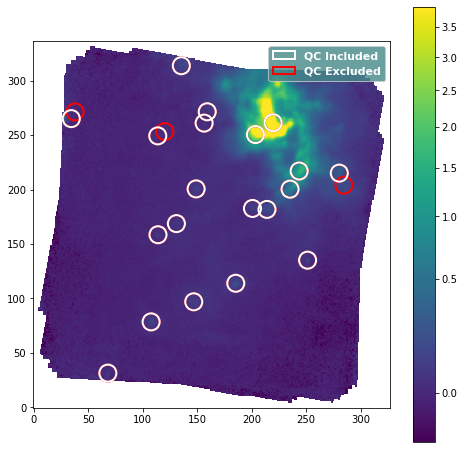

In [87]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

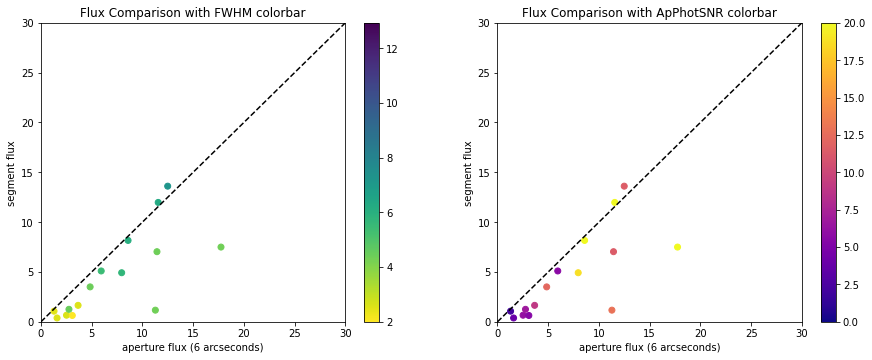

In [88]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

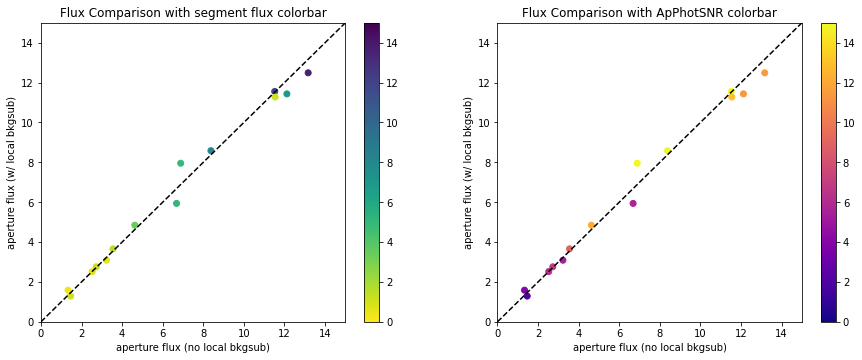

In [89]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [90]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)